# Basic Movie Recommender
DataSet:
 - This dataset is from [Open Movie Database](http://www.omdbapi.com/)
 - It was downloaded from their website using the APIs provided
 - We have roughly 65K movies and their attributes such as rating, vote count and actors etc.
 
Objective:
 - Build a basic movie recommender that recommends movies based on a score
 - The score for a movie is calculated based on number of votes and the ratings
 - Higher score translates to higher recommendation

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage import io

In [65]:
movies = pd.read_json('movies.json')

In [66]:
movies.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,DVD,BoxOffice,Production,Website,Response,Season,Episode,seriesID,totalSeasons,Error
0,Toy Story,1995,G,22 Nov 1995,81 min,"Animation, Adventure, Comedy, Family, Fantasy",John Lasseter,"John Lasseter (original story by), Pete Docter...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney",A little boy named Andy loves to be in his roo...,...,20 Mar 2001,N/A,Buena Vista,N/A,True,None,None,None,None,None
1,Jumanji,1995,PG,15 Dec 1995,104 min,"Adventure, Comedy, Family, Fantasy",Joe Johnston,"Jonathan Hensleigh (screenplay by), Greg Taylo...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",After being trapped in a jungle board game for...,...,25 Jan 2000,N/A,Sony Pictures Home Entertainment,N/A,True,None,None,None,None,None
2,Grumpier Old Men,1995,PG-13,22 Dec 1995,101 min,"Comedy, Romance",Howard Deutch,"Mark Steven Johnson (characters), Mark Steven ...","Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Things don't seem to change much in Wabasha Co...,...,18 Nov 1997,N/A,Warner Home Video,N/A,True,None,None,None,None,None
3,Waiting to Exhale,1995,R,22 Dec 1995,124 min,"Comedy, Drama, Romance",Forest Whitaker,"Terry McMillan (novel), Terry McMillan (screen...","Whitney Houston, Angela Bassett, Loretta Devin...",This story based on the best selling novel by ...,...,06 Mar 2001,N/A,Twentieth Century Fox Home Entertainment,N/A,True,None,None,None,None,None
4,Father of the Bride Part II,1995,PG,08 Dec 1995,106 min,"Comedy, Family, Romance",Charles Shyer,"Albert Hackett (screenplay ""Father's Little Di...","Steve Martin, Diane Keaton, Martin Short, Kimb...","In this sequel to ""Father of the Bride"", Georg...",...,09 May 2000,N/A,Disney,N/A,True,None,None,None,None,None


For the basic movie recommender, I will be using imdbRating and imdbVotes

In [67]:
movies = movies[['Title','imdbRating','imdbVotes','Poster']]

Lets check our data for missing values

In [68]:
movies.isnull().sum(axis=0)

Title         7
imdbRating    5
imdbVotes     5
Poster        5
dtype: int64

Looks like we have some NAs. Lets take care of these

In [69]:
indexes_to_drop = movies[(movies.Title.isnull()==True) | (movies.imdbRating=='N/A') | (movies.imdbVotes=='N/A')].index

In [70]:
movies = movies.drop(axis='index', index=indexes_to_drop)

Lets make sure everything is clean now

In [71]:
movies[(movies.Title.isnull()==True) | (movies.imdbRating=='N/A') | (movies.imdbVotes=='N/A')]

,Title,imdbRating,imdbVotes,Poster


Cool!, All clean now. Lets convert imdbRating and imdbVotes to Numbers

In [72]:
movies.imdbRating = movies.imdbRating.astype(float)

In [73]:
movies.imdbVotes  = movies.imdbVotes.replace(",","", regex=True)
movies.imdbVotes = movies.imdbVotes.astype(int)

In [74]:
movies.imdbRating.describe()

count    61982.000000
mean         6.279065
std          1.177493
min          1.200000
25%          5.600000
50%          6.500000
75%          7.100000
max          9.900000
Name: imdbRating, dtype: float64

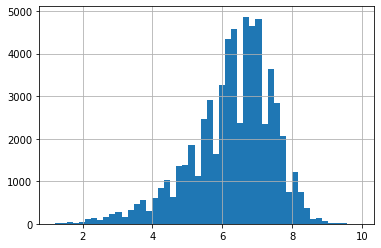

In [75]:
movies.imdbRating.hist(bins=50)
plt.show()

we can see that the plot is almost normal with a little bit of skew to the left. We have fewer highly rated movies than the average or below average movies.

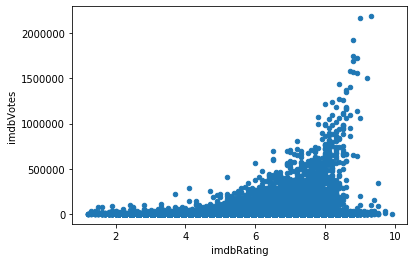

In [76]:
movies.plot(kind='scatter',x='imdbRating', y='imdbVotes')
plt.show()

Highly rated movies generally have higher number of votes

Calculate score Using the (Bayesian Average) formula below

$
\begin{align}
score = \frac{v}{(v+m)}{.r} + \frac{m}{(v+m)}{.c}
\end{align}
$

 - v : the number of votes for the movies
 - m : minium number of votes needed to qualify for listing
 - r : movie rating
 - c : mean movie rating across all movies

In [77]:
c = movies.imdbRating.mean()
print(c)

6.279064889806717


In [78]:
movies.describe()
m = round(movies.imdbVotes.quantile(0.9),0)
print(m)

17230.0


using 17230 as minimum number of votes needed to qualify for listing

In [79]:
def calc_score(x, m=m, c=c):
    v = x['imdbVotes']
    r = x['imdbRating']
    return v/(v+m) *r + m/(v+m) *c

In [80]:
base_recommended_movies = movies[movies.imdbVotes > m].copy()

In [81]:
base_recommended_movies.loc[:,'score'] =  base_recommended_movies.apply(calc_score, axis=1).values

In [96]:
base_recommended_movies.sort_values(by='score', ascending=False, axis=0, inplace=True, ignore_index=True)

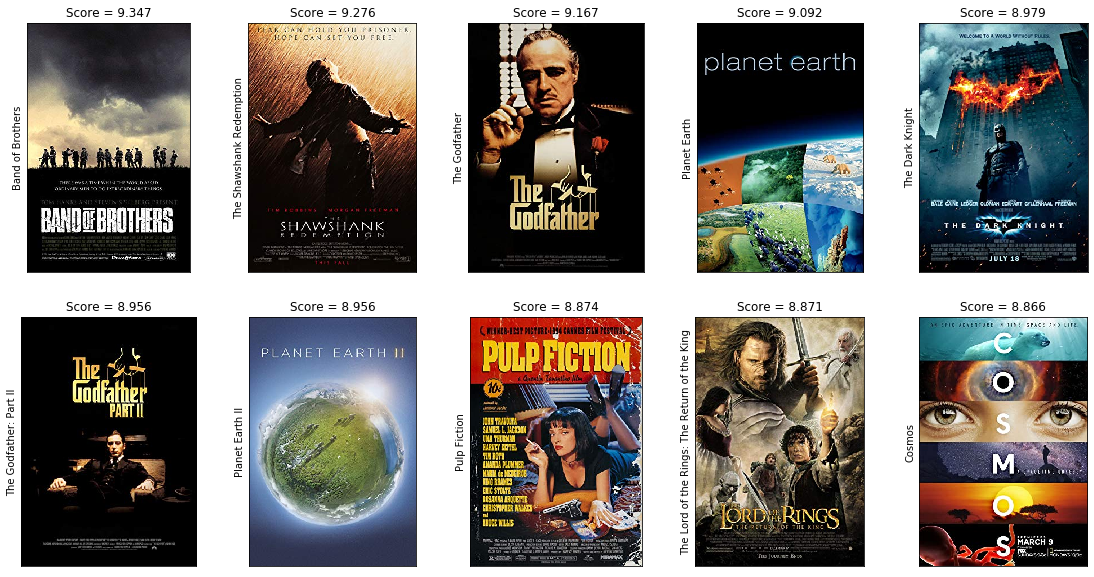

In [157]:
plt.figure(figsize = (20, 10))
gs = gridspec.GridSpec(2, 5)
gs.update(wspace=0.01, hspace=0.18)
for i in range(10):
    image = io.imread(base_recommended_movies.iloc[i]['Poster'])
    ax = plt.subplot(gs[i])
    ax.imshow(image)
    ax.set_ylabel(base_recommended_movies.iloc[i]['Title']) 
    ax.set_title('Score = ' + str(round(base_recommended_movies.iloc[i]['score'],3)))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Cool! The list contains some of my favorite movies too.